In [1]:
import argparse
import os
import datasets
import torch
import math
import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ddpm
import seaborn

from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset , Dataset

from tqdm.auto import tqdm

from positional_embeddings import PositionalEmbedding


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression , Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.decomposition import PCA




In [21]:
class Block(nn.Module):
    def __init__(self, size: int):
        super().__init__()
        self.ff = nn.Linear(size, size)              # Couche linéaire
        self.act = nn.GELU()                         # Fonction d'activation GELU

    def forward(self, x: torch.Tensor):
        return x + self.act(self.ff(x))              # Residual connection


class MLP(nn.Module):
    def __init__(self, input_dim: int, hidden_size: int = 128, hidden_layers: int = 3,
                 emb_size: int = 128, time_emb: str = "sinusoidal", input_emb: str = "sinusoidal"):
        super().__init__()

        self.time_mlp = PositionalEmbedding(emb_size, time_emb)                     # Embedding par rapport au temps
        self.input_mlps = nn.ModuleList([PositionalEmbedding(emb_size, input_emb, scale=25.0)
                                         for _ in range(input_dim)])                # Embedding pour chaque dimension de l'entrée

        concat_size = len(self.time_mlp.layer) + len(self.input_mlps) * emb_size
        layers = [nn.Linear(concat_size, hidden_size), nn.GELU()]                  # Initialise la première couche
        for _ in range(hidden_layers):
            layers.append(Block(hidden_size))                                      # Crée les layers cachés
        layers.append(nn.Linear(hidden_size, input_dim))                           # Final layer de taille input_dim
        self.joint_mlp = nn.Sequential(*layers)                                    # Ajoute tous les layers

    def forward(self, x, t):
        x_embs = [self.input_mlps[i](x[:, i]) for i in range(x.size(1))]           # Embedding pour chaque dimension de x
        t_emb = self.time_mlp(t)
        x = torch.cat(x_embs + [t_emb], dim=-1)                                    # Concaténation des embeddings
        x = self.joint_mlp(x)                                                      # Application du réseau de neurones
        return x

    

In [22]:
data = pd.read_csv('raw_data.csv')
data["coord_x"]=data["coord_x"]/(10**6)*40.43-22.18
data["coord_y"]=data["coord_y"]/(10**6)*62.07-387.42
dataset = data[['coord_x', 'coord_y']].values    
#dataset = data[['coord_x', 'coord_y','heure','mois','jour','sin_rank']].valuesdataset = data[['coord_x', 'coord_y','heure','mois','jour','sin_rank']].values
tensor = torch.from_numpy(dataset)

dataset = TensorDataset(tensor)
data_tensor = dataset.tensors[0] #Transformation des données sous la même forme que X_cross, dino , moons etc

min_val = torch.min(data_tensor, dim=0)[0]
max_val = torch.max(data_tensor, dim=0)[0]
print(max_val)

tensor([3.0510, 4.4071], dtype=torch.float64)


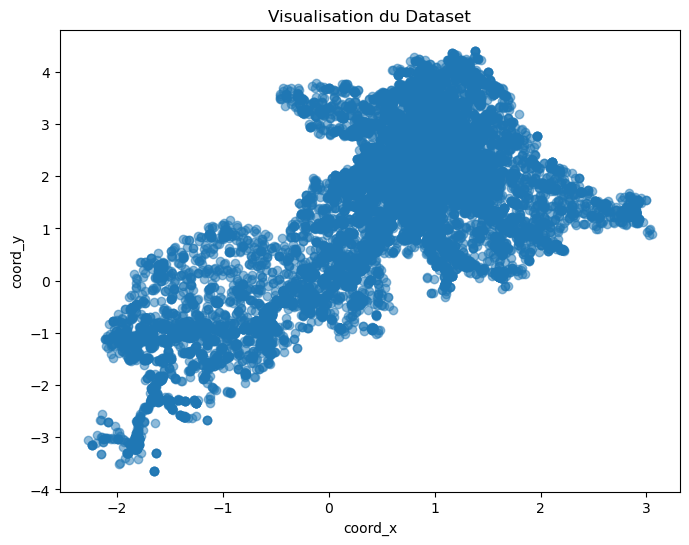

tensor([[1.0108, 2.4325],
        [0.4010, 1.3820],
        [1.0391, 2.3519],
        ...,
        [0.8366, 2.5444],
        [1.0179, 2.1746],
        [1.1463, 2.3189]], dtype=torch.float64)


In [23]:
plt.figure(figsize=(8, 6))
plt.scatter(data_tensor[:, 0].numpy(), data_tensor[:, 1].numpy(), alpha=0.5)
plt.title("Visualisation du Dataset")
plt.xlabel("coord_x")
plt.ylabel("coord_y")
plt.show()

print(data_tensor)


(tensor([[1.0108, 2.4325],
        [0.4010, 1.3820],
        [1.0391, 2.3519],
        ...,
        [0.9315, 2.2243],
        [0.8366, 2.5444],
        [1.0179, 2.1746]], dtype=torch.float64),)


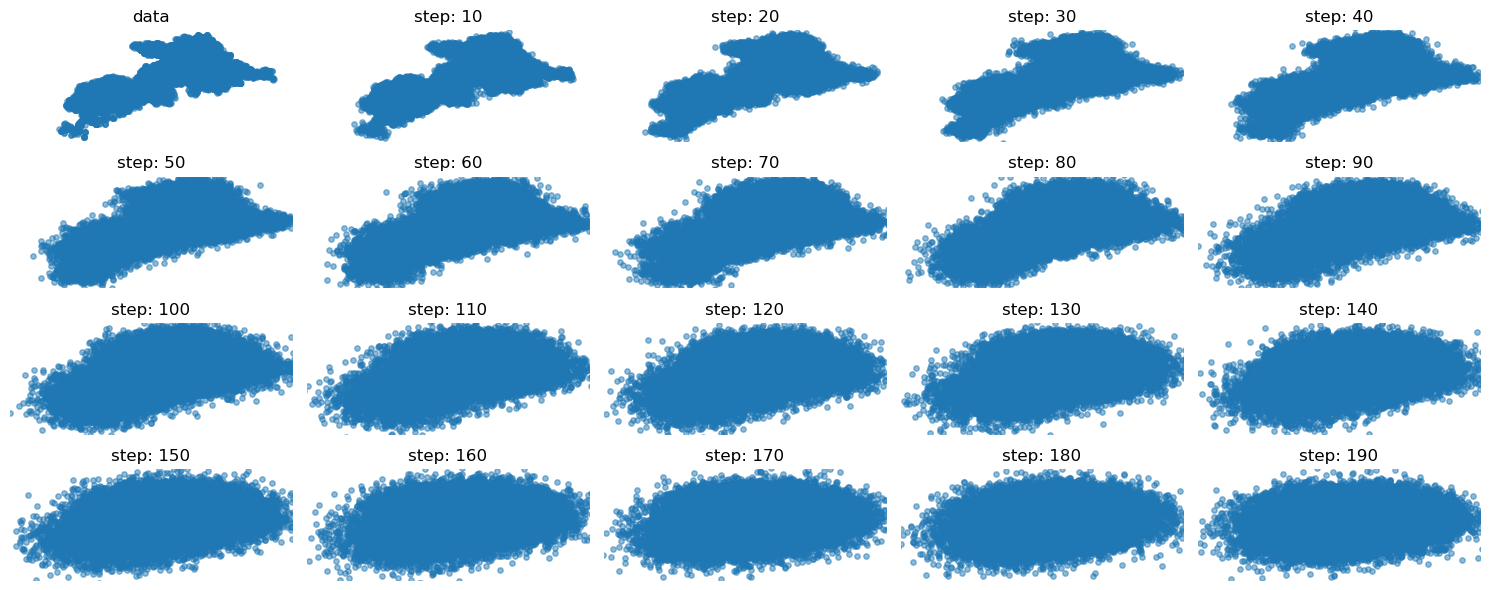

In [24]:
num_timesteps = 200
plot_step = 10

num_plots = math.ceil(num_timesteps / plot_step)
num_cols = 5
num_rows = math.ceil(num_plots / num_cols)

fig = plt.figure(figsize=(15, 6))

noise_scheduler = ddpm.NoiseScheduler(num_timesteps=num_timesteps)
x0 = dataset.tensors[0]
t=np.zeros(len(x0))
    
print(dataset[0:-1])
plt_cnt = 1
plt.subplot(num_rows, num_cols, plt_cnt)
plt.scatter(x0[:, 0], x0[:, 1], alpha=0.5, s=15)
plt.title("data")
plt.xlim(-3.5, 3.5)
plt.ylim(-4., 4.75)
plt.axis("off")
        
for t in range(len(noise_scheduler)):
    timesteps = np.repeat(t, len(x0))
    noise = torch.randn_like(x0)
    sample = noise_scheduler.add_noise(x0, noise, timesteps)
    if (t + 1) % plot_step == 0 and (t + 1) != len(noise_scheduler):
        plt_cnt += 1
        plt.subplot(num_rows, num_cols, plt_cnt)
        plt.scatter(sample[:, 0], sample[:, 1], alpha=0.5, s=15)
        plt.title(f"step: {t + 1}")
        plt.xlim(-3.5, 3.5)
        plt.ylim(-4., 4.75)
        plt.axis("off")
        
fig.tight_layout()


In [25]:
num_epochs=400
lr=10**(-3)
num_timesteps=100
hidden_size=256
hidden_layers=3
time_emb="sinusoidal"
input_emb="sinusoidal"
batch_size=50
emb_size=128
save_images_step=num_epochs/10
input_dim=2


dataloader = DataLoader(dataset, batch_size, shuffle=True, drop_last=True)
model = MLP(input_dim, hidden_size, hidden_layers,
                 emb_size, time_emb, input_emb)
noise_scheduler = ddpm.NoiseScheduler(num_timesteps, beta_end=0.02, beta_schedule="linear")

optimizer = torch.optim.AdamW(model.parameters(), lr)
global_step = 0
frames = []
losses = []

print("Training model...")
for epoch in range(num_epochs):
    model.train()
    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, batch in enumerate(dataloader):
        batch = batch[0]
        noise = torch.randn(batch.shape).float()  # Assurez-vous que le bruit est de type float
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()

        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        noisy = noisy.float()  # Assurez-vous que le tenseur noisy est de type float
        noise_pred = model(noisy, timesteps)
        
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "step": global_step}
        losses.append(loss.detach().item())
        progress_bar.set_postfix(**logs)
        global_step += 1
    progress_bar.close()

    if epoch == num_epochs - 1:
        print("Generating final sample...")
        model.eval()
        with torch.no_grad():
            sample = torch.randn(batch_size, 2).float()
            timesteps = list(range(noise_scheduler.num_timesteps))[::-1]
            for t in tqdm(timesteps):
                t = torch.full((batch_size,), t).long()
                residual = model(sample, t)
                sample = noise_scheduler.step(residual, t[0], sample)


print("Saving model...")
outdir = "exps/base"
os.makedirs(outdir, exist_ok=True)
torch.save(model.state_dict(), f"{outdir}/model.pth")



Training model...


  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

Generating final sample...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving model...


  0%|          | 0/100 [00:00<?, ?it/s]

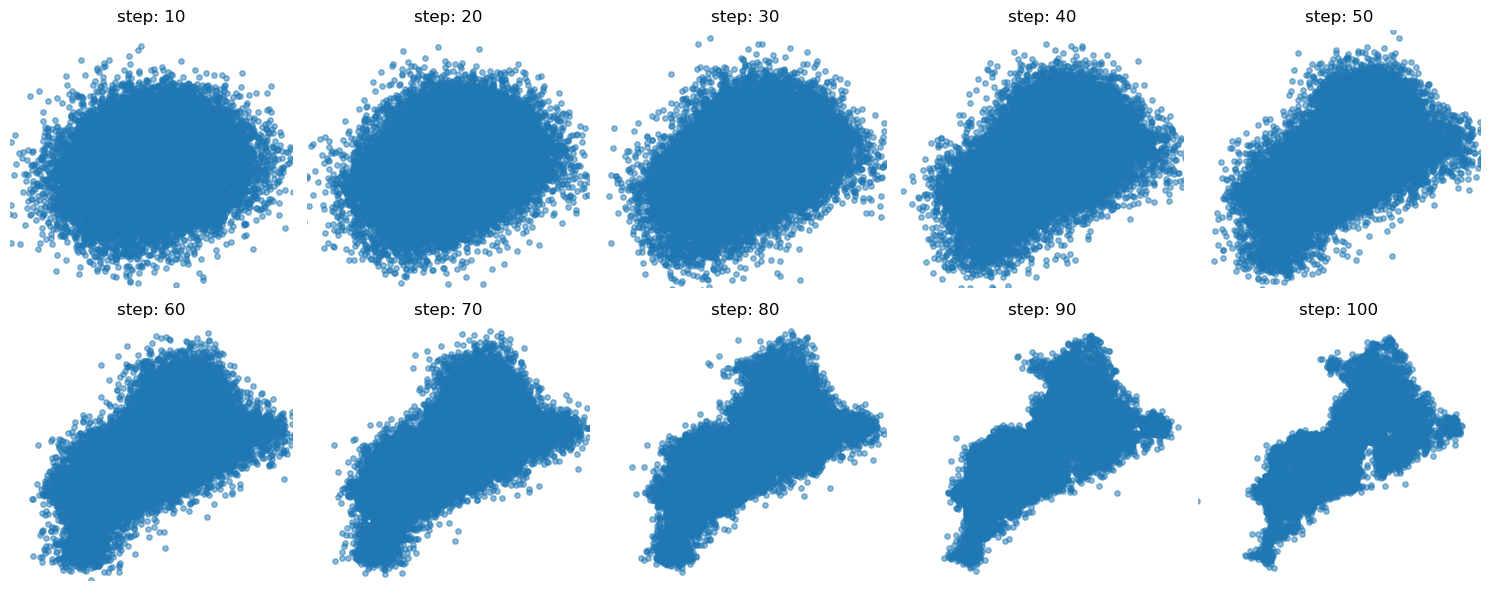

<Figure size 640x480 with 0 Axes>

In [31]:
for j in range(1): 
    eval_batch_size = 30000
    num_timesteps = 100
    plot_step = 10
    sample = torch.randn(eval_batch_size, 2)
    timesteps = list(range(num_timesteps))[::-1]
    samples = []
    steps = []
    for i, t in enumerate(tqdm(timesteps)):
        t = torch.from_numpy(np.repeat(t, eval_batch_size)).long()
        with torch.no_grad():
            residual = model(sample, t)
        sample = noise_scheduler.step(residual, t[0], sample)
        if (i + 1) % plot_step == 0:
            samples.append(sample.numpy())
            steps.append(i + 1)

    num_cols = 5
    num_rows = math.ceil(len(samples) / num_cols)
    fig = plt.figure(figsize=(15, 6))
    for i, sample in enumerate(samples):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.scatter(sample[:, 0], sample[:, 1], alpha=0.5, s=15)
        plt.title(f"step: {steps[i]}")
        plt.xlim(-3.5, 3.5)
        plt.ylim(-4., 4.75)
        plt.axis("off")
    fig.tight_layout()
    plt.savefig("lr=10^-2", facecolor="white")

    plt.show()
    plt.figure()

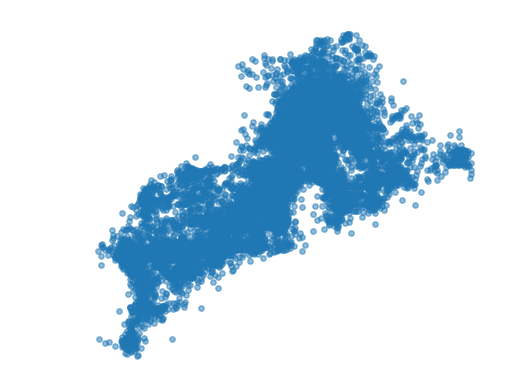

<Figure size 640x480 with 0 Axes>

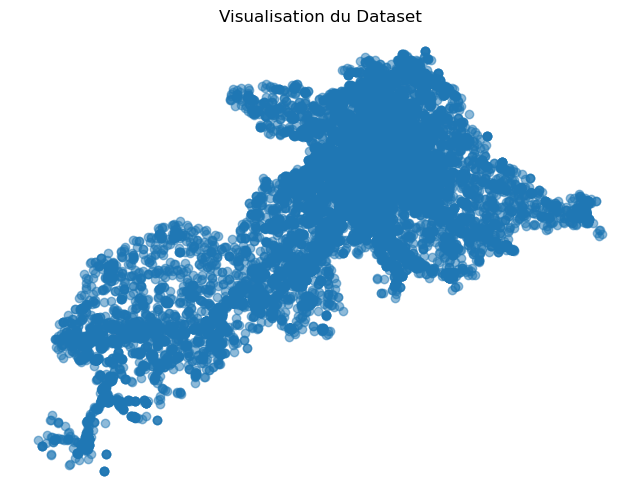

tensor([[1.0108, 2.4325],
        [0.4010, 1.3820],
        [1.0391, 2.3519],
        ...,
        [0.8366, 2.5444],
        [1.0179, 2.1746],
        [1.1463, 2.3189]], dtype=torch.float64)


In [30]:
last_sample = sample
# Créez une nouvelle figure pour le dernier graphique.
plt.figure()

# Créez un seul graphique.
plt.scatter(last_sample[:, 0], last_sample[:, 1], alpha=0.5, s=15)
plt.xlim(-3.5, 3.5)
plt.ylim(-4., 4.75)
plt.axis("off")

# Enregistrez l'image du dernier graphique.
plt.savefig("last_step_plot.png", facecolor="white")

# Affichez le graphique.
plt.show()
plt.figure()

plt.figure(figsize=(8, 6))
plt.scatter(data_tensor[:, 0].numpy(), data_tensor[:, 1].numpy(), alpha=0.5)
plt.title("Visualisation du Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.axis("off")
plt.show()

print(data_tensor)

In [34]:
generated_data=samples[-1]
df = pd.DataFrame(generated_data, columns=["coord_x", "coord_y"])
df["coord_x"]=(df["coord_x"]+22.18)*10**6 /(40.43)
df["coord_y"]=(df["coord_y"]+387.42)*10**6 /(62.07)
# Affichage du DataFrame

df.describe()


,coord_x,coord_y
count,30000.000000,3.000000e+04
mean,555373.827830,6.251789e+06
std,28109.341427,2.612366e+04
min,477734.362168,6.118064e+06
25%,533364.888261,6.230061e+06
50%,565458.906779,6.256762e+06
75%,575367.130031,6.275447e+06
max,670634.441201,6.310524e+06


In [35]:
data = pd.read_csv('raw_data.csv')
data = data.drop(columns=['mois'])
data = data.drop(columns=['jour'])
data = data.drop(columns=['heure'])
data = data.drop(columns=['duree'])
data = data.drop(columns=['sin_rank'])
data.describe()

,coord_x,coord_y
count,53467.000000,5.346700e+04
mean,566973.571288,6.271184e+06
std,19635.863331,2.011204e+04
min,492349.280000,6.183028e+06
25%,564677.000000,6.266005e+06
50%,572290.500000,6.277595e+06
75%,575507.000000,6.281217e+06
max,624065.200000,6.312665e+06


# Partie 2 : modèle de diffusion pour n données différentes :

In [12]:
data = pd.read_csv('raw_data.csv')
data["coord_x"]=data["coord_x"]/(10**6)*40.43-22.18
data["coord_y"]=data["coord_y"]/(10**6)*62.07-387.42
data["heure"]=np.sin(data["heure"]*np.pi/12)*3
data["jour"]=np.sin(2*data["jour"]*np.pi/365)*3
data["sin_rank"]=data["sin_rank"]*0.141-3.78
data["duree"]=data["duree"]*0.0068-3.72
#dataset = data[['coord_x', 'coord_y','heure']].values    
dataset = data[['coord_x', 'coord_y','heure','jour','sin_rank','duree']].values


#heure jour et mois -> passer à du sin

tensor = torch.from_numpy(dataset)

dataset = TensorDataset(tensor)
data_tensor = dataset.tensors[0] #Transformation des données sous la même forme que X_cross, dino , moons etc
print(data_tensor.shape)



torch.Size([53467, 6])


(tensor([[ 1.0108,  2.4325,  0.0000,  0.0000, -3.2160, -3.3528],
        [ 0.4010,  1.3820,  0.0000,  0.0000, -1.2420, -3.5024],
        [ 1.0391,  2.3519,  0.0000,  0.0000, -2.7930, -3.5500],
        ...,
        [ 0.9315,  2.2243, -0.7765, -0.0516, -1.1010, -0.2996],
        [ 0.8366,  2.5444, -0.7765, -0.0516, -3.2160, -3.1284],
        [ 1.0179,  2.1746, -0.7765, -0.0516, -2.0880, -0.3268]],
       dtype=torch.float64),)


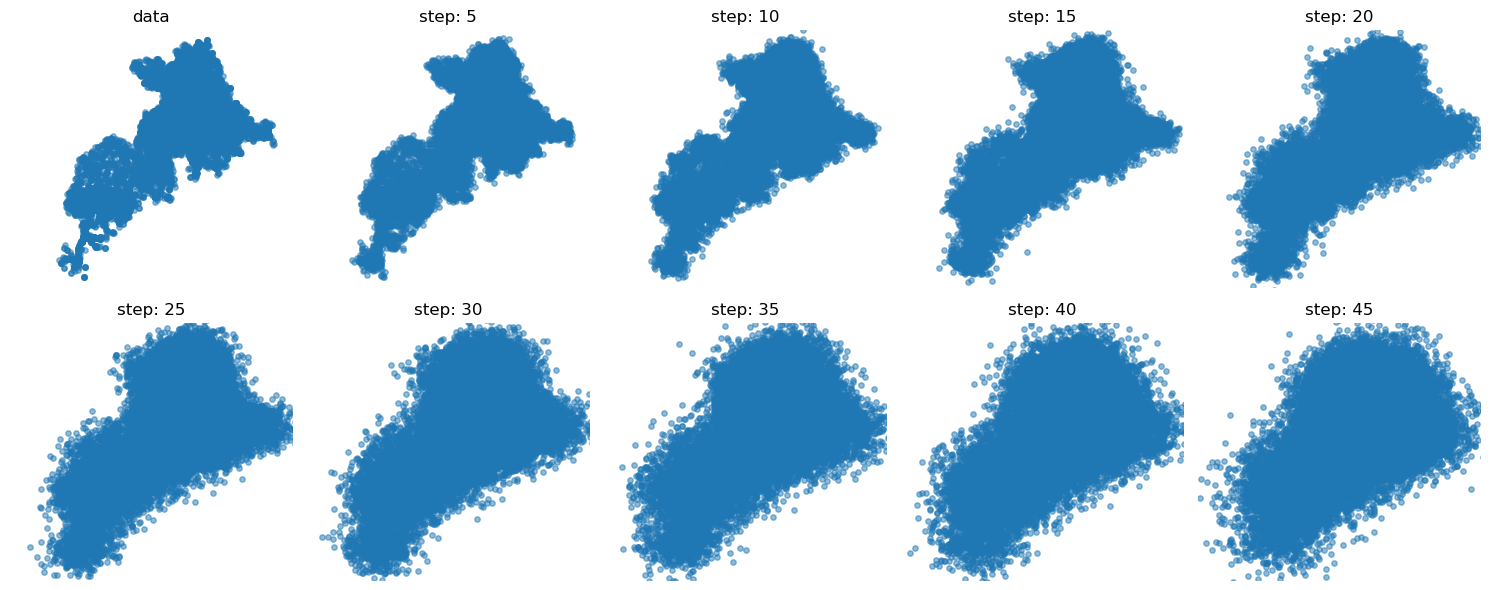

In [13]:
num_timesteps = 50
plot_step = 5

num_plots = math.ceil(num_timesteps / plot_step)
num_cols = 5
num_rows = math.ceil(num_plots / num_cols)

fig = plt.figure(figsize=(15, 6))

noise_scheduler = ddpm.NoiseScheduler(num_timesteps=num_timesteps)
x0 = dataset.tensors[0]
t=np.zeros(len(x0))
    
print(dataset[0:-1])
plt_cnt = 1
plt.subplot(num_rows, num_cols, plt_cnt)
plt.scatter(x0[:, 0], x0[:, 1], alpha=0.5, s=15)
plt.title("data")
plt.xlim(-3.5, 3.5)
plt.ylim(-4., 4.75)
plt.axis("off")
        
for t in range(len(noise_scheduler)):
    timesteps = np.repeat(t, len(x0))
    noise = torch.randn_like(x0)
    sample = noise_scheduler.add_noise(x0, noise, timesteps)
    if (t + 1) % plot_step == 0 and (t + 1) != len(noise_scheduler):
        plt_cnt += 1
        plt.subplot(num_rows, num_cols, plt_cnt)
        plt.scatter(sample[:, 0], sample[:, 1], alpha=0.5, s=15)
        plt.title(f"step: {t + 1}")
        plt.xlim(-3.5, 3.5)
        plt.ylim(-4., 4.75)
        plt.axis("off")        
fig.tight_layout()


In [14]:
class Block(nn.Module):
    def __init__(self, size: int):
        super().__init__()
        self.ff = nn.Linear(size, size)              # Couche linéaire
        self.act = nn.GELU()                         # Fonction d'activation GELU

    def forward(self, x: torch.Tensor):
        return x + self.act(self.ff(x))              # Residual connection


class MLP(nn.Module):
    def __init__(self, input_dim: int, hidden_size: int = 128, hidden_layers: int = 3,
                 emb_size: int = 128, time_emb: str = "sinusoidal", input_emb: str = "sinusoidal"):
        super().__init__()

        self.time_mlp = PositionalEmbedding(emb_size, time_emb)                     # Embedding par rapport au temps
        self.input_mlps = nn.ModuleList([PositionalEmbedding(emb_size, input_emb, scale=25.0)
                                         for _ in range(input_dim)])                # Embedding pour chaque dimension de l'entrée

        concat_size = len(self.time_mlp.layer) + len(self.input_mlps) * emb_size
        layers = [nn.Linear(concat_size, hidden_size), nn.GELU()]                  # Initialise la première couche
        for _ in range(hidden_layers):
            layers.append(Block(hidden_size))                                      # Crée les layers cachés
        layers.append(nn.Linear(hidden_size, input_dim))                           # Final layer de taille input_dim
        self.joint_mlp = nn.Sequential(*layers)                                    # Ajoute tous les layers

    def forward(self, x, t):
        x_embs = [self.input_mlps[i](x[:, i]) for i in range(x.size(1))]           # Embedding pour chaque dimension de x
        t_emb = self.time_mlp(t)
        x = torch.cat(x_embs + [t_emb], dim=-1)                                    # Concaténation des embeddings
        x = self.joint_mlp(x)                                                      # Application du réseau de neurones
        return x


In [15]:
num_epochs = 400
lr = 1e-4
num_timesteps = 100
hidden_size = 256
hidden_layers = 2
time_emb = "sinusoidal"
input_emb = "sinusoidal"
batch_size = 50
emb_size = 128
save_images_step = 100
input_dim = 6


dataloader = DataLoader(dataset, batch_size, shuffle=True, drop_last=True)
model = MLP(input_dim, hidden_size, hidden_layers, emb_size, time_emb, input_emb)
noise_scheduler = ddpm.NoiseScheduler(num_timesteps, beta_end=0.02, beta_schedule="linear")

optimizer = torch.optim.AdamW(model.parameters(), lr)
global_step = 0
frames = []
losses = []


print("Training model")
for epoch in range(num_epochs):
    model.train()
    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, batch in enumerate(dataloader):
        batch = batch[0]
        noise = torch.randn(batch.shape).float()  # Assurez-vous que le bruit est de type float
        timesteps = torch.randint(0, noise_scheduler.num_timesteps, (batch.shape[0],)).long()

        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        noisy = noisy.float()  # Assurez-vous que le tenseur noisy est de type float
        noise_pred = model(noisy, timesteps)
        
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "step": global_step}
        losses.append(loss.detach().item())
        progress_bar.set_postfix(**logs)
        global_step += 1
    progress_bar.close()

print("Saving model...")
outdir = "exps/base"
os.makedirs(outdir, exist_ok=True)
torch.save(model.state_dict(), f"{outdir}/modelNDlr10-3.pth")



Training model


  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

Saving model...


  0%|          | 0/100 [00:00<?, ?it/s]

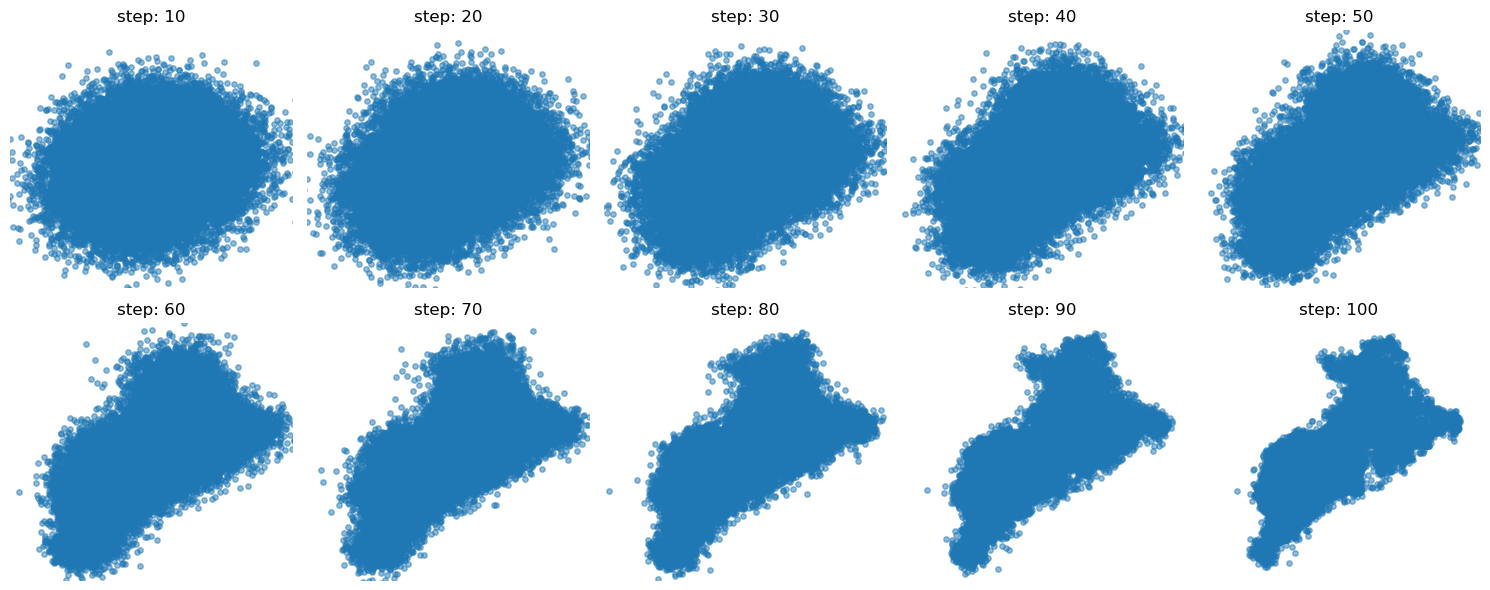

<Figure size 640x480 with 0 Axes>

In [16]:
# Visualisation des données générées
for j in range(1):
    eval_batch_size = 53467
    num_timesteps = 100
    plot_step = 10
    sample = torch.randn(eval_batch_size, input_dim)
    timesteps = list(range(num_timesteps))[::-1]
    samples = []
    steps = []
    for i, t in enumerate(tqdm(timesteps)):
        t = torch.from_numpy(np.repeat(t, eval_batch_size)).long()
        with torch.no_grad():
            residual = model(sample, t)
        sample = noise_scheduler.step(residual, t[0], sample)
        if (i + 1) % plot_step == 0:
            samples.append(sample.numpy())
            steps.append(i + 1)

    num_cols = 5
    num_rows = math.ceil(len(samples) / num_cols)
    fig = plt.figure(figsize=(15, 6))
    for i, sample in enumerate(samples):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.scatter(sample[:, 0], sample[:, 1], alpha=0.5, s=15)
        plt.title(f"step: {steps[i]}")
        plt.xlim(-3.5, 3.5)
        plt.ylim(-4., 4.75)
        plt.axis("off")
    fig.tight_layout()
    plt.savefig(f"lr=1e-3_epoch_{epoch}.png", facecolor="white")
    plt.show()
    plt.figure()


In [49]:
print(sample.shape)
generated_data=samples[1]
df = pd.DataFrame(generated_data, columns=['coord_x', 'coord_y','heure','jour','sin_rank','duree'])
df["coord_x"]=(df["coord_x"]+22.18)*10**6 /(40.43)
df["coord_y"]=(df["coord_y"]+387.42)*10**6 /(62.07)
#df["heure"]=((df["heure"]+3.78)/0.068).astype(int)
#df["jour"]=((df["jour"]+3.64)/0.022).astype(int)
df["sin_rank"]=((df["sin_rank"]+3.78)/0.141).astype(int)
df["duree"]=((df["duree"]+3.72)/0.0068).astype(int)



df.describe()



(53467, 6)


,coord_x,coord_y,heure,jour,sin_rank,duree
count,53467.000000,5.346700e+04,53467.000000,53467.000000,53467.000000,53467.000000
mean,550847.340035,6.245669e+06,-0.028119,0.007134,24.534012,451.028878
std,24618.549910,1.822828e+04,1.254779,1.239921,9.444755,189.223450
min,433935.636699,6.166503e+06,-4.039577,-4.172419,-8.000000,-163.000000
25%,534083.776594,6.232944e+06,-0.972398,-0.879193,17.000000,318.000000
50%,551468.129504,6.246181e+06,-0.026383,-0.035392,24.000000,413.000000
75%,567927.420685,6.258868e+06,0.893254,0.914635,31.000000,552.000000
max,669206.500850,6.308592e+06,4.507701,4.062044,59.000000,1336.000000


In [9]:
data = pd.read_csv('raw_data.csv')
data.describe()

,coord_x,coord_y,mois,jour,heure,duree,sin_rank
count,53467.000000,5.346700e+04,53467.000000,53467.000000,53467.000000,53467.000000,53467.000000
mean,566973.571288,6.271184e+06,6.450296,179.486749,13.279163,88.404586,11.773580
std,19635.863331,2.011204e+04,3.399603,103.916785,6.204177,58.028826,13.460249
min,492349.280000,6.183028e+06,1.000000,0.000000,0.000000,11.000000,1.000000
25%,564677.000000,6.266005e+06,4.000000,90.000000,9.000000,54.000000,2.000000
50%,572290.500000,6.277595e+06,6.000000,178.000000,14.000000,80.000000,6.000000
75%,575507.000000,6.281217e+06,9.000000,268.000000,18.000000,109.000000,17.000000
max,624065.200000,6.312665e+06,12.000000,364.000000,23.000000,1184.000000,58.000000


Les heures sont réparties sur l'intervalle [0 , 123] ce qui est très mauvais, d'autant plus que le premier quartile est déjà à 43.  Les jours sont répartis sur l'intervalle [-150 , 370] , les quartiles sont cependant plus proches de la réalité. Finalement , pour le type de sinistres , ils sont répartis sur l'intervalle [1,71] ce qui est également mauvais. On va essayer de redimensionner les données pour voir si cela colle déjà plus à la réalité

$$
\begin{align}
x_{\text{min}} \cdot a + b &= y_\text{min}  \Leftrightarrow a=\frac{y_\text{max}-y_\text{min}}{x_{\text{max}}-x_{\text{min}}} \\ 
x_{\text{max}} \cdot a + b &= y_\text{max} \Leftrightarrow b=\frac{x_\text{max}y_\text{min}-y_\text{max}x_\text{min}}{x_\text{max}-x_\text{min}}\\
\end{align}
$$


In [48]:
h_min, h_max = df['heure'].min(), df['heure'].max()
s_min, s_max = df['sin_rank'].min(), df['sin_rank'].max()
j_min, j_max = df['jour'].min(), df['jour'].max()
d_min, d_max = df['duree'].min(), df['duree'].max()

a = 23 / (h_max - h_min)
b = -a * h_min  
df["heure"] = (df["heure"] * a + b).astype(int)

a = 364 / (j_max - j_min)
b = -a * j_min  
df["jour"] = (df["jour"] * a + b).astype(int)

a = 57 / (s_max - s_min)
b = -a * s_min + 1  
df["sin_rank"] = (df["sin_rank"] * a + b).astype(int)

a= (1184-11)/(d_max-d_min)
b= -a * d_min + d_min
df['duree'] = (df["duree"] * a + b).astype(int)

df.describe()


,coord_x,coord_y,heure,jour,sin_rank,duree
count,53467.000000,5.346700e+04,53467.000000,53467.000000,53467.000000,53467.000000
mean,550847.340035,6.245669e+06,8.972226,196.152412,28.178259,316.989433
std,24618.549910,1.822828e+04,2.490635,38.865335,8.030552,148.065760
min,433935.636699,6.166503e+06,0.000000,0.000000,1.000000,-163.000000
25%,534083.776594,6.232944e+06,7.000000,169.000000,22.000000,213.000000
50%,551468.129504,6.246181e+06,9.000000,195.000000,28.000000,287.000000
75%,567927.420685,6.258868e+06,11.000000,224.000000,34.000000,396.000000
max,669206.500850,6.308592e+06,23.000000,364.000000,58.000000,1010.000000


Commençons par comparer les différentes quartiles :

Pour les coordonnées x et y , la moyenne , et les quartiles sont semblables au dataset de base.
Pour le jour , l'écart type est à 214 contre 178 dans les données de base ce qui est beaucoup plus cohérent.
Pour les heures , les quartiles ne correspondent pas une fois de plus.
Pour le type de sinistres , les quartiles ne correspondent pas à nouveau.
Finalement pour les duree , les deux premiers quartiles sont assez proches , mais le 3ème quartile est beaucoup trop élevé.

En conclusion , les valeurs élevées et les évènement "rares" sont surreprésentés, les données générées ne semblent pas vraiment efficaces. Testons un autre learning rate pour l'entrainement du modèle.

In [4]:
data = pd.read_csv('raw_data.csv')
data["coord_x"]=data["coord_x"]/(10**6)*40.43-22.18
data["coord_y"]=data["coord_y"]/(10**6)*62.07-387.42
data["heure"]=np.sin(data["heure"]*np.pi/12)*3
data["jour"]=np.sin(2*data["jour"]*np.pi/365)*3
data["sin_rank"]=data["sin_rank"]*0.141-3.78
data["duree"]=data["duree"]*0.0068-3.72
#dataset = data[['coord_x', 'coord_y','heure']].values    
dataset = data[['coord_x', 'coord_y','heure','jour','sin_rank','duree']].values


#heure jour et mois -> passer à du sin

tensor = torch.from_numpy(dataset)

dataset = TensorDataset(tensor)
data_tensor = dataset.tensors[0] #Transformation des données sous la même forme que X_cross, dino , moons etc
print(data_tensor.shape)



torch.Size([53467, 6])


In [5]:
num_epochs = 200
lr = 1e-4
num_timesteps = 100
hidden_size = 256
hidden_layers = 2
time_emb = "sinusoidal"
input_emb = "sinusoidal"
batch_size = 50
emb_size = 128
save_images_step = 100
input_dim = 6


dataloader = DataLoader(dataset, batch_size, shuffle=True, drop_last=True)
model = MLP(input_dim, hidden_size, hidden_layers, emb_size, time_emb, input_emb)
noise_scheduler = ddpm.NoiseScheduler(num_timesteps, beta_end=0.02, beta_schedule="linear")

optimizer = torch.optim.AdamW(model.parameters(), lr)
global_step = 0
frames = []
losses = []


print("Training model")
for epoch in range(num_epochs):
    model.train()
    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, batch in enumerate(dataloader):
        batch = batch[0]
        noise = torch.randn(batch.shape).float()  # Assurez-vous que le bruit est de type float
        timesteps = torch.randint(0, noise_scheduler.num_timesteps, (batch.shape[0],)).long()

        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        noisy = noisy.float()  # Assurez-vous que le tenseur noisy est de type float
        noise_pred = model(noisy, timesteps)
        
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "step": global_step}
        losses.append(loss.detach().item())
        progress_bar.set_postfix(**logs)
        global_step += 1
    progress_bar.close()

print("Saving model...")
outdir = "exps/base"
os.makedirs(outdir, exist_ok=True)
torch.save(model.state_dict(), f"{outdir}/modelNDlr10-3.pth")



Training model


  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

  0%|          | 0/1069 [00:00<?, ?it/s]

Saving model...


  0%|          | 0/100 [00:00<?, ?it/s]

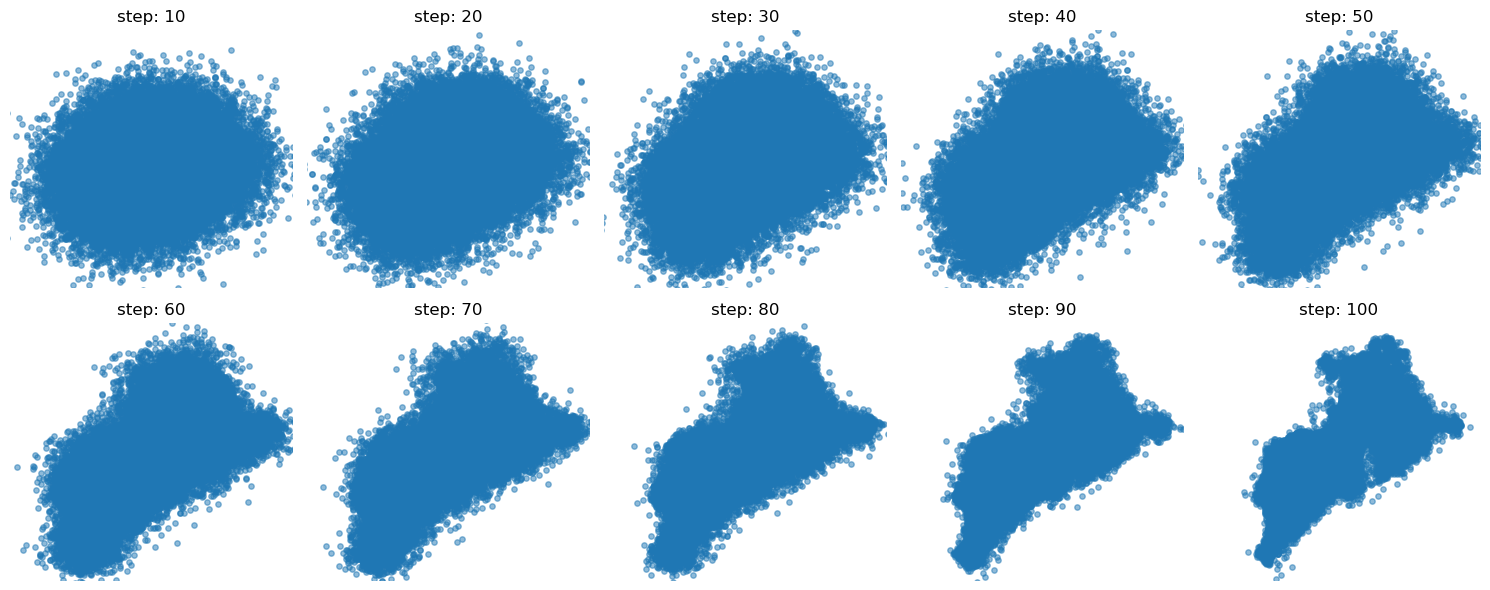

  0%|          | 0/100 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

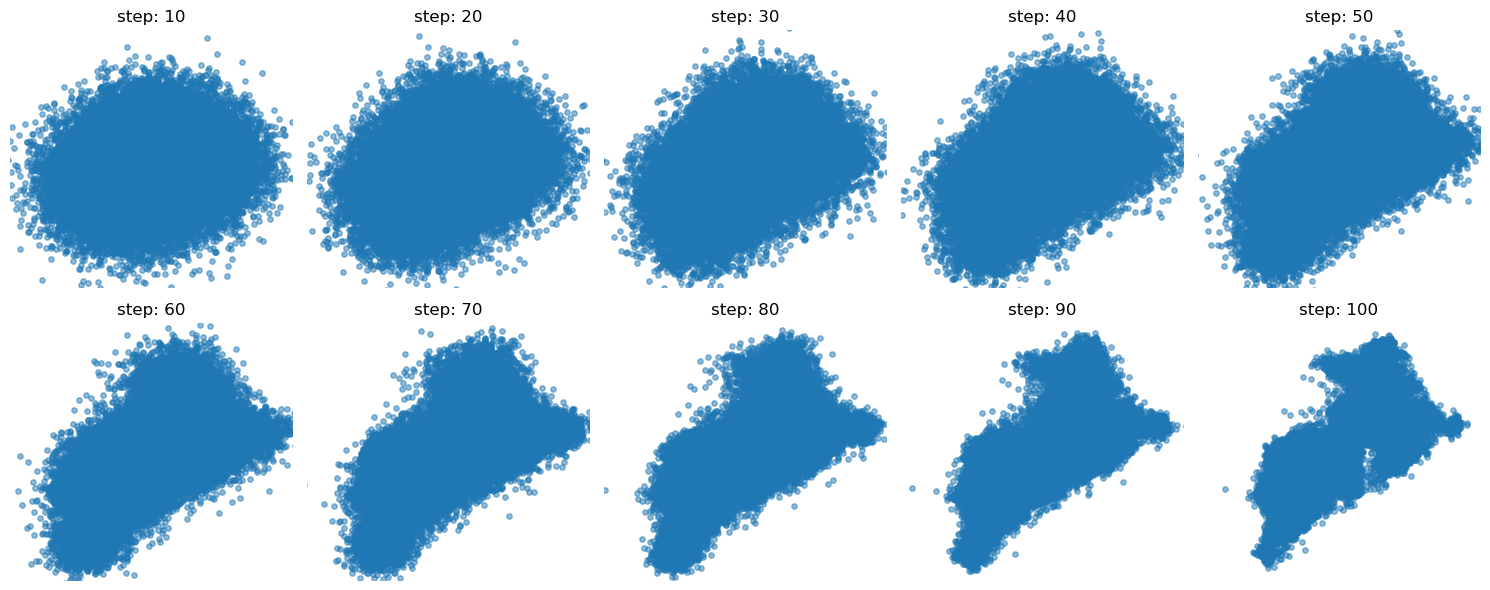

  0%|          | 0/100 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

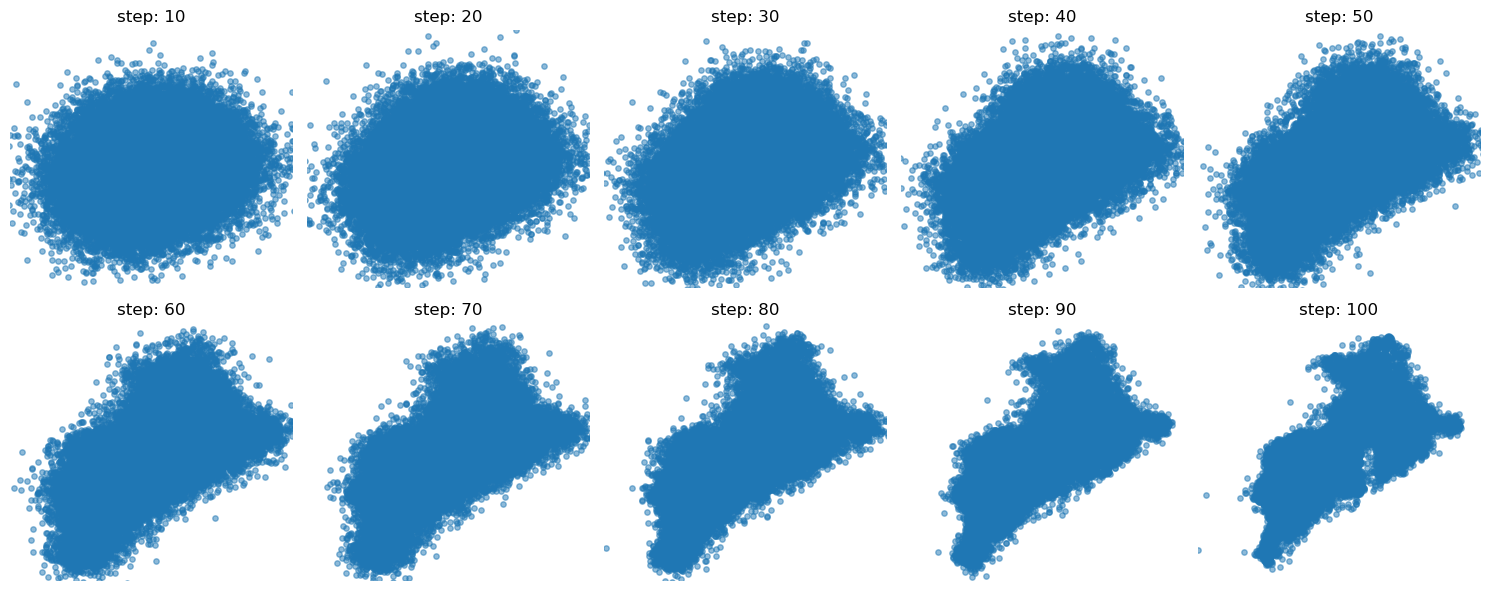

<Figure size 640x480 with 0 Axes>

In [6]:
# Visualisation des données générées
for j in range(3):
    eval_batch_size = 53467
    num_timesteps = 100
    plot_step = 10
    sample = torch.randn(eval_batch_size, input_dim)
    timesteps = list(range(num_timesteps))[::-1]
    samples = []
    steps = []
    for i, t in enumerate(tqdm(timesteps)):
        t = torch.from_numpy(np.repeat(t, eval_batch_size)).long()
        with torch.no_grad():
            residual = model(sample, t)
        sample = noise_scheduler.step(residual, t[0], sample)
        if (i + 1) % plot_step == 0:
            samples.append(sample.numpy())
            steps.append(i + 1)

    num_cols = 5
    num_rows = math.ceil(len(samples) / num_cols)
    fig = plt.figure(figsize=(15, 6))
    for i, sample in enumerate(samples):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.scatter(sample[:, 0], sample[:, 1], alpha=0.5, s=15)
        plt.title(f"step: {steps[i]}")
        plt.xlim(-3.5, 3.5)
        plt.ylim(-4., 4.75)
        plt.axis("off")
    fig.tight_layout()
    plt.savefig(f"lr=1e-3_epoch_{epoch}.png", facecolor="white")
    plt.show()
    plt.figure()


In [7]:
print("Saving model...")
outdir = "exps/base"
os.makedirs(outdir, exist_ok=True)
torch.save(model.state_dict(), f"{outdir}/modelNDlr10-4.pth")

Saving model...


In [14]:
print(sample.shape)
generated_data=samples[-1]
df = pd.DataFrame(generated_data, columns=['coord_x', 'coord_y','heure','jour','sin_rank','duree'])
df["coord_x"]=(df["coord_x"]+22.18)*10**6 /(40.43)
df["coord_y"]=(df["coord_y"]+387.42)*10**6 /(62.07)
h_min, h_max = df['heure'].min(), df['heure'].max()
j_min,j_max = df['jour'].min() , df["jour"].max()

ah=6/(h_max-h_min)
bh=-ah/2*(h_max+h_min)
aj=6/(j_max-j_min)
bj=-aj/2*(j_max+j_min)

df["heure"]=(24*np.arcsin((ah*df["heure"]+bh)/3)/np.pi+12).astype(int)
df["jour"]=(365*np.arcsin((aj*df["jour"]+bj)/3)/np.pi+365/2).astype(int)
df["sin_rank"]=((df["sin_rank"]+3.78)/0.141).astype(int)
df["duree"]=((df["duree"]+3.72)/0.0068).astype(int)


df.describe()



(53467, 6)


,coord_x,coord_y,heure,jour,sin_rank,duree
count,53467.000000,5.346700e+04,53467.000000,53467.000000,53467.000000,53467.000000
mean,554848.559920,6.252526e+06,11.017637,184.257149,22.515028,257.902089
std,27489.551017,2.448193e+04,5.337312,79.639448,14.666396,272.348278
min,461816.799514,6.147925e+06,0.000000,0.000000,0.000000,5.000000
25%,533879.714351,6.233823e+06,8.000000,134.000000,9.000000,83.000000
50%,562819.283462,6.252789e+06,11.000000,177.000000,22.000000,134.000000
75%,574744.552661,6.276155e+06,15.000000,244.000000,33.000000,324.000000
max,623516.042192,6.311175e+06,24.000000,365.000000,58.000000,1565.000000


Avec un learning rate lr=10^(-4) , on obtiens des intervales légèrement meilleurs pour le type de sinistre ; l'heure et la durée 

In [20]:
#s_min, s_max = df['sin_rank'].min(), df['sin_rank'].max()
#d_min, d_max = df['duree'].min(), df['duree'].max()

#a = 57 / (s_max - s_min)
#b = -a * s_min + 1  
#df["sin_rank"] = (df["sin_rank"] * a + b).astype(int)

#a= (1184-11)/(d_max-d_min)
#b= -a * d_min + d_min
#df['duree'] = (df["duree"] * a + b).astype(int)

#df.describe()
data = pd.read_csv('raw_data.csv')
data.describe()

,coord_x,coord_y,mois,jour,heure,duree,sin_rank
count,53467.000000,5.346700e+04,53467.000000,53467.000000,53467.000000,53467.000000,53467.000000
mean,566973.571288,6.271184e+06,6.450296,179.486749,13.279163,88.404586,11.773580
std,19635.863331,2.011204e+04,3.399603,103.916785,6.204177,58.028826,13.460249
min,492349.280000,6.183028e+06,1.000000,0.000000,0.000000,11.000000,1.000000
25%,564677.000000,6.266005e+06,4.000000,90.000000,9.000000,54.000000,2.000000
50%,572290.500000,6.277595e+06,6.000000,178.000000,14.000000,80.000000,6.000000
75%,575507.000000,6.281217e+06,9.000000,268.000000,18.000000,109.000000,17.000000
max,624065.200000,6.312665e+06,12.000000,364.000000,23.000000,1184.000000,58.000000


<Axes: xlabel='sin_rank', ylabel='nombre_interventions'>

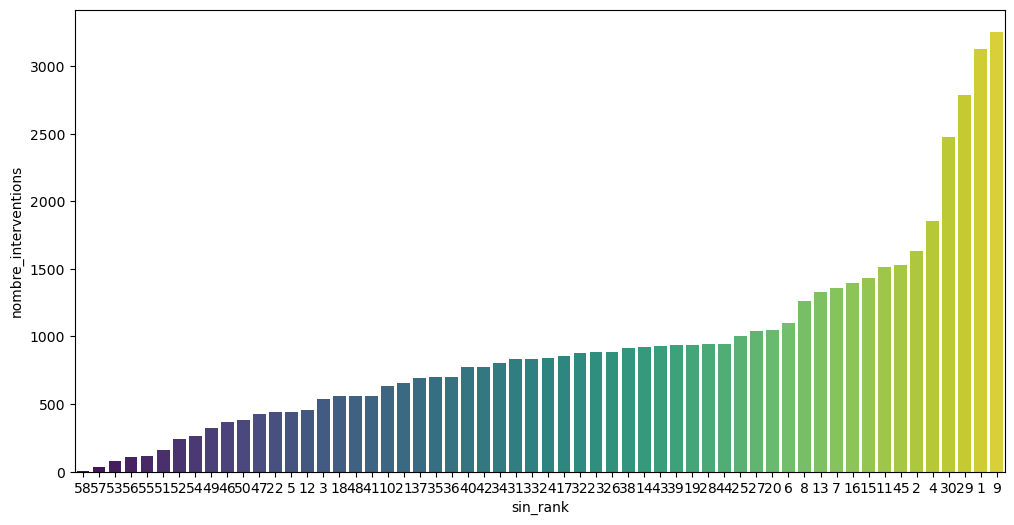

In [16]:
nombre_interventions = df.groupby("sin_rank")["duree"].count().reset_index(name="nombre_interventions")

# Trier les résultats par nombre d'interventions croissant 
nombre_interventions = nombre_interventions.sort_values(by="nombre_interventions")


plt.figure(figsize=(12, 6))
seaborn.barplot(x="sin_rank", y="nombre_interventions", data=nombre_interventions, palette="viridis", order=nombre_interventions["sin_rank"])

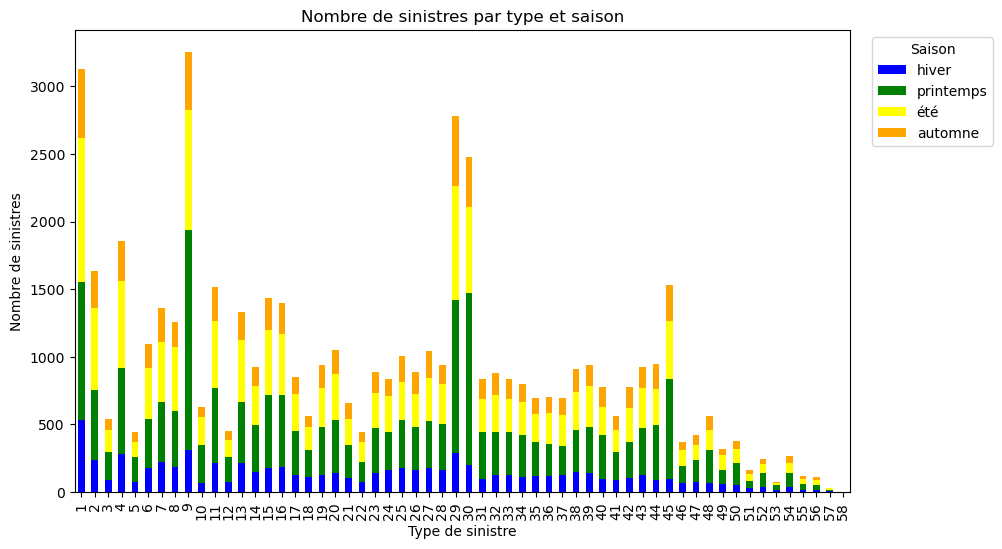

In [17]:
df["saison"] = pd.cut(df["jour"], bins=4, labels=["hiver", "printemps", "été", "automne"])
sinistre_counts = df.groupby(['sin_rank', 'saison']).size().reset_index(name='count')

# Pivotez les données pour avoir les saisons en colonnes
sinistre_counts = sinistre_counts.pivot(index='sin_rank', columns='saison', values='count').fillna(0)
couleurs = {'printemps': 'green', 'été': 'yellow', 'automne': 'orange', 'hiver': 'blue'}


fig, ax = plt.subplots(figsize=(10, 6))
ax = sinistre_counts.plot(kind='bar', stacked=True, ax=ax, color=[couleurs[saison] for saison in sinistre_counts.columns])
ax.set_xlabel('Type de sinistre')
ax.set_ylabel('Nombre de sinistres')
ax.set_title('Nombre de sinistres par type et saison')
ax.legend(title='Saison', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.show()

In [18]:
borne_inf=10
borne_sup=40

# Compter le nombre de sinistres pour chaque type de sinistre et chaque saison
sinistre_counts = df.groupby(['sin_rank', 'saison']).size().reset_index(name='count')

# Pivotez les données pour avoir les saisons en colonnes
sinistre_counts = sinistre_counts.pivot(index='sin_rank', columns='saison', values='count').fillna(0)

total_sinistres = sinistre_counts.sum(axis=1)
sinistre_counts = sinistre_counts.div(total_sinistres, axis=0) * 100


saison_max = sinistre_counts.idxmax(axis=1)
max_pct = sinistre_counts.max(axis=1)

saison_min = sinistre_counts.idxmin(axis=1)
min_pct = sinistre_counts.min(axis=1)

for sin_rank, max_saison, min_saison, max_pct_val, min_pct_val in zip(sinistre_counts.index, saison_max, saison_min, max_pct, min_pct):
    if max_pct_val >= borne_sup or min_pct_val <= borne_inf:
        print(f"Type de sinistre {sin_rank}:")
        print(f"  Saison avec le plus d'occurrences ({max_pct_val:.2f}%) : {max_saison}")
        print(f"  Saison avec le moins d'occurrences ({min_pct_val:.2f}%) : {min_saison}")
        print()

Type de sinistre 5:
  Saison avec le plus d'occurrences (42.89%) : printemps
  Saison avec le moins d'occurrences (16.03%) : hiver

Type de sinistre 9:
  Saison avec le plus d'occurrences (50.08%) : printemps
  Saison avec le moins d'occurrences (9.52%) : hiver

Type de sinistre 10:
  Saison avec le plus d'occurrences (44.60%) : printemps
  Saison avec le moins d'occurrences (10.32%) : hiver

Type de sinistre 29:
  Saison avec le plus d'occurrences (40.48%) : printemps
  Saison avec le moins d'occurrences (10.42%) : hiver

Type de sinistre 30:
  Saison avec le plus d'occurrences (51.23%) : printemps
  Saison avec le moins d'occurrences (8.20%) : hiver

Type de sinistre 31:
  Saison avec le plus d'occurrences (41.32%) : printemps
  Saison avec le moins d'occurrences (11.38%) : hiver

Type de sinistre 40:
  Saison avec le plus d'occurrences (42.04%) : printemps
  Saison avec le moins d'occurrences (12.16%) : hiver

Type de sinistre 44:
  Saison avec le plus d'occurrences (43.02%) : print

Une fois de plus , on observe beaucoup trop de cas extrêmes. De plus , les sinsitres pour lesquels la distribution n'était pas uniforme , c'est à dire le 10 , le 40  ou le 55 , n'ont plus une distribution non uniforme.

On en conclus que lorsque les données deviennent de trop grande dimension , la génération n'est pas bonne et donc elle est inutilisable.